## Finding Ellipticities of CAMELS Galaxies and correlating Their Shape with Dark Matter Density.

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors 
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
import h5py
import hdf5plugin
import treecorr
import time

In [66]:
def ellipticity(centre, theta, weight, x_y_or_z='z'):
    '''Calculates the ellipticity of a galaxy given its centre and positions of stellar particles
    centre - 3D position of Centre of galaxy
    theta - 3D position of stars
    x_y_or_z: from whcih axis do we want to calculate out 2D ellipticity
    weight - weighting of each star - defined as the density of space around that star'''
    xyz = {'x':[1,2], 'y':[2,0], 'z':[0,1]}
    perp_ax = xyz[x_y_or_z]
    centre = np.array([centre[perp_ax[0]], centre[perp_ax[1]]]).T       # 2D
    theta = np.array([theta[:,perp_ax[0]], theta[:,perp_ax[1]]]).T        # 2D
    separation = (theta - centre) %25 #calculating separations of members from cluster centre
    for i in range(separation.shape[0]):
        for j in range(2):  # Iterate over x, y, and z components
            if separation[i, j] < -10:
                separation[i, j] += 25
            elif separation[i, j] > 10:
                separation[i, j] -= 25
    prob = weight/np.max(weight)
    prob = np.array([prob,prob]).T # multiply x and y coord
    separation_scaled = np.multiply(separation, prob)

    Q = (separation.T.dot(separation_scaled))         #'the correlation matrix'
    epsilon = (Q[0, 0] - Q[1, 1] + 2j*Q[0,1])/(Q[0, 0] + Q[1,1] + 2*np.sqrt(np.linalg.det(Q)))				#epsilon

    return epsilon

In [67]:
filenum = 868
# Importing snapshot and catalogue data at redshift z=0
snapshot = f'C:\CAMELS DATA\LH{filenum}_snap_033IllustrisTNG.hdf5' # snapshot name
# open the snapshot
f = h5py.File(snapshot, 'r')
pos_dm = f['PartType1/Coordinates'][:]/1e3  #positions of dark matter in Mpc/h
pos_s = f['PartType4/Coordinates'][:]/1e3  # star positions in Mpc/h
mass_s = f['PartType4/Masses'][:]*1e10  # star masses in Mpc/h

# close file
f.close()
# catalogue name
catalogue = f'C:\CAMELS DATA\LH{filenum}_fof_subhalo_tab_033.hdf5'
# open the catalogue
f = h5py.File(catalogue, 'r')
# looking to see data in cataloge
# def print_dataset_name(name,g):
#     print(name,'&',g)
# f.visititems(print_dataset_name)
pos_sh  = f['Subhalo/SubhaloPos'][:]/1e3     #positions of SUBFIND subhalos in Mpc/h
subh_M_R_12 = f['Subhalo/SubhaloMassInRadType'][:,4]*1e10 # total stellar mass of twice the stellare alf-mass radius in Msun/h
nstar_h = f['Group/GroupLenType'][:,4]            # total number of stars in each halo
nstar_sh = f['Subhalo/SubhaloLenType'][:,4]            # total number of stars in each subhalo
n_subhalos = f['Group/GroupNsubs'][:]
# close file
f.close()

In [68]:
print('Total number of subhalos: ',np.sum(n_subhalos))
print("Total number of halos: ", len(n_subhalos))
print("Number of stars: ",len(pos_s))
print("Number of stars in halos: ",np.sum(nstar_h))
print("Number of stars in subhalos: ",np.sum(nstar_sh))

Total number of subhalos:  17557
Total number of halos:  18741
Number of stars:  937246
Number of stars in halos:  935640
Number of stars in subhalos:  935192


In [5]:
print(start,stop)

NameError: name 'start' is not defined

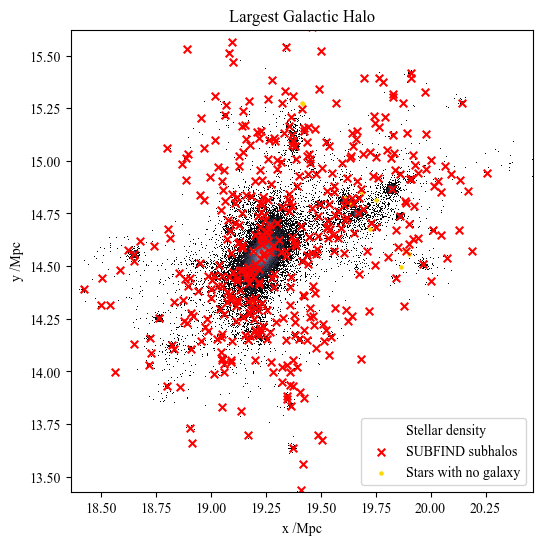

In [69]:
s_first_h = nstar_h[0] # number of stars in first halo
stop = s_first_h
s = n_subhalos[0] # number of subhalos in first halo
start = np.sum(nstar_sh[:s])
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
hist = ax.hist2d(pos_s[:stop, 1], pos_s[:stop, 0], cmap='bone', norm=colors.LogNorm(), bins=500)
sc1 = ax.scatter(pos_s[start:stop, 1], pos_s[start:stop, 0], marker='o', s=5, alpha=1.0, c='gold', label='Stars with no galaxy')
sc2 = ax.scatter(pos_sh[:s, 1], pos_sh[:s, 0], marker='x', s=30, alpha=1, c='r', label='SUBFIND subhalos')
ax.set_xlabel('x /Mpc')
ax.set_ylabel('y /Mpc')
ax.set_title('Largest Galactic Halo')
ax.set_box_aspect(1)

# Create a dummy artist for the hist2d plot to add it to the legend
dummy_artist = plt.Line2D([], [], linestyle='-', linewidth=1, color='white', label='Stellar density')
# Combine scatter plots and the dummy artist in the legend
handles = [dummy_artist, sc2, sc1]
labels = [handle.get_label() for handle in handles]
ax.legend(handles=handles, labels=labels)

plt.show()

#### Assigning every star to a subhalo according to SUBFIND algorithm
If a star does not belong to a subhalo but belongs to a halo, it does not get assigned an index. Stars which do not belong to any halo are at the end of the arrays thus do not get counted.

In [72]:
assigned = np.zeros(len(pos_s), dtype=bool) # Initialize an array to keep track of assigned star particles
# store the assignment of each star particle to a galaxy particle
assignment = -np.ones(len(pos_s), dtype=int)  # The index of the galaxy particle, for unassigned stars assignment =-1

begin_slice = 0
end_slice = nstar_sh[0] # end_slice - begin_silice = number of stars assigned to this subhalo w index subhalo_index
star_count = 0 # star index we are at
subhalo_index = 0   # subhalo index we are at

for i, number_sh in enumerate(n_subhalos): 
    if number_sh!=0: 
        for j in range(number_sh):          # looping through every subhalo in a halo
            
            assigned[begin_slice:end_slice] = True
            assignment[begin_slice:end_slice] = subhalo_index
            
            if nstar_sh[subhalo_index]!=0:
                begin_slice=end_slice
                if subhalo_index+1 <17557:
                    end_slice = begin_slice + nstar_sh[subhalo_index+1]

            star_count += nstar_sh[subhalo_index]
            
            subhalo_index +=1

                

        old_star_count = star_count
        star_count = np.sum(nstar_h[:i+1])
        #print("unasigned stars: ", star_count - old_star_count)
        begin_slice = star_count   # skipping the stars with no subhalo
        if subhalo_index!=len(nstar_sh):
            end_slice = star_count+nstar_sh[subhalo_index]
    else:
        continue
print("It is",np.sum(n_subhalos)==subhalo_index, "we have counted all subhalos.")

It is True we have counted all subhalos.


Text(0, 0.5, 'subhalo index')

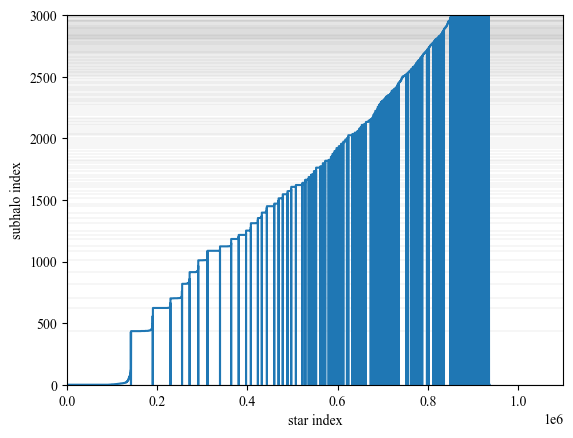

In [73]:
for __ in range(len(n_subhalos)):
    plt.axhline(np.sum(n_subhalos[:__]),c='0.5',linewidth=0.1)
plt.plot(assignment[:])
plt.xlim([0,1.1e6])
plt.ylim([0,3000])
plt.xlabel('star index')
plt.ylabel('subhalo index')

#### Galaxies are subhalos with Mstar > 1e8 Msun

In [74]:
# removing unasigned stars from star index
pos_s1 = pos_s[assigned]
mass_s1 = mass_s[assigned]
assignment1 = assignment[assigned]
# replacing subhalos with low stellar mass with np.nan
pos_g = pos_sh
pos_g[subh_M_R_12<1e8] = np.nan
pos_g2 = pos_g[~np.isnan(pos_g).any(axis=1)] # sifting 
nstar_g = nstar_sh.astype(float)
nstar_g[subh_M_R_12<1e8] = np.nan
print('Galaxy positions shape: ', pos_g.shape)

high_mass = np.where((subh_M_R_12 > 1e8) & (nstar_sh > 0))[0]
print(high_mass.shape, "galaxies")

# Create a boolean mask for the stars above the threshold mass
mask = np.isin(assignment, high_mass)

# Filter out stars in subhalos below the threshold mass
pos_s2 = pos_s[mask]
mass_s2 = mass_s[mask]
filtered_assignment1 = assignment[mask]
print("number of stars remaining:",filtered_assignment1.shape)

Galaxy positions shape:  (17557, 3)
(1524,) galaxies
number of stars remaining: (926968,)


In [75]:
unique_values, counts = np.unique(filtered_assignment1, return_counts=True)
len(unique_values)
print(filtered_assignment1.shape)

(926968,)


In [76]:
e_glxys = {} # dictionary for ellipticities 
for axis in ['x','y','z']:
    e_glxys[axis] = 3.0*np.ones(len(pos_g), dtype = 'complex_') # set non calaculated values to 3
assigned2 = np.zeros(len(pos_g), dtype=bool)
for axis in ['x','y','z']:
    for i in range(len(pos_g)):
        if ~np.isnan(nstar_g[i]):
            print(i,len(mass_s2[filtered_assignment1==i]), pos_s2[filtered_assignment1==i].shape,"{:.3E}".format(subh_M_R_12[i]))
            if len(mass_s2[filtered_assignment1==i])>0: # some stars are not assigned to a galaxy?
                assigned2[i]=True
                e_glxys[axis][i] = ellipticity(centre=pos_g[i], theta=pos_s2[filtered_assignment1==i],
                                               weight=mass_s2[filtered_assignment1==i], x_y_or_z=axis)
  

0 93290 (93290, 3) 5.644E+11
1 4041 (4041, 3) 2.544E+10
2 1896 (1896, 3) 1.290E+10
3 5508 (5508, 3) 3.599E+10
4 2143 (2143, 3) 1.359E+10
5 3437 (3437, 3) 2.168E+10
6 1580 (1580, 3) 1.076E+10
7 2559 (2559, 3) 1.651E+10
8 2410 (2410, 3) 1.624E+10
9 1708 (1708, 3) 1.192E+10
10 1419 (1419, 3) 9.682E+09
11 3095 (3095, 3) 2.323E+10
12 1402 (1402, 3) 9.937E+09
13 840 (840, 3) 5.812E+09
14 1904 (1904, 3) 1.213E+10
15 1265 (1265, 3) 7.725E+09
16 427 (427, 3) 2.996E+09
17 959 (959, 3) 6.709E+09
18 1154 (1154, 3) 7.770E+09
19 370 (370, 3) 2.678E+09
20 107 (107, 3) 7.791E+08
21 175 (175, 3) 1.363E+09
22 60 (60, 3) 5.007E+08
23 692 (692, 3) 4.974E+09
24 56 (56, 3) 4.389E+08
25 678 (678, 3) 5.148E+09
26 166 (166, 3) 1.201E+09
27 292 (292, 3) 2.288E+09
28 63 (63, 3) 5.181E+08
29 415 (415, 3) 3.062E+09
30 192 (192, 3) 1.410E+09
31 66 (66, 3) 5.102E+08
32 215 (215, 3) 1.680E+09
33 394 (394, 3) 2.847E+09
34 441 (441, 3) 3.199E+09
35 197 (197, 3) 1.454E+09
37 14 (14, 3) 1.392E+08
38 315 (315, 3) 2.516E+0

1255 315 (315, 3) 2.256E+09
1256 180 (180, 3) 1.436E+09
1257 25 (25, 3) 2.111E+08
1258 164 (164, 3) 1.201E+09
1259 152 (152, 3) 1.299E+09
1260 31 (31, 3) 2.471E+08
1262 12 (12, 3) 1.027E+08
1283 0 (0, 3) 4.318E+08
1311 10641 (10641, 3) 6.488E+10
1312 3059 (3059, 3) 1.921E+10
1313 1461 (1461, 3) 1.025E+10
1314 104 (104, 3) 8.464E+08
1315 127 (127, 3) 1.044E+09
1316 62 (62, 3) 5.410E+08
1317 34 (34, 3) 3.161E+08
1319 31 (31, 3) 2.618E+08
1320 21 (21, 3) 2.006E+08
1353 4042 (4042, 3) 2.178E+10
1354 2306 (2306, 3) 1.547E+10
1355 1190 (1190, 3) 9.749E+09
1356 819 (819, 3) 5.847E+09
1357 170 (170, 3) 1.332E+09
1359 46 (46, 3) 3.767E+08
1363 0 (0, 3) 5.986E+08
1397 6950 (6950, 3) 3.964E+10
1398 794 (794, 3) 5.115E+09
1399 768 (768, 3) 5.547E+09
1400 343 (343, 3) 2.428E+09
1401 552 (552, 3) 3.698E+09
1402 432 (432, 3) 3.316E+09
1403 160 (160, 3) 1.270E+09
1404 365 (365, 3) 2.845E+09
1406 189 (189, 3) 1.457E+09
1407 32 (32, 3) 2.468E+08
1409 48 (48, 3) 4.377E+08
1411 108 (108, 3) 8.502E+08
1412

2503 2656 (2656, 3) 1.713E+10
2507 1859 (1859, 3) 1.236E+10
2513 3397 (3397, 3) 1.983E+10
2520 1807 (1807, 3) 1.172E+10
2521 145 (145, 3) 1.094E+09
2522 18 (18, 3) 1.656E+08
2523 169 (169, 3) 1.570E+09
2529 1943 (1943, 3) 1.265E+10
2530 13 (13, 3) 1.036E+08
2535 1779 (1779, 3) 1.063E+10
2542 948 (948, 3) 5.877E+09
2543 966 (966, 3) 6.933E+09
2548 1801 (1801, 3) 1.211E+10
2550 112 (112, 3) 7.323E+08
2554 1056 (1056, 3) 7.035E+09
2555 79 (79, 3) 6.515E+08
2561 1713 (1713, 3) 1.145E+10
2566 1861 (1861, 3) 1.194E+10
2575 1319 (1319, 3) 8.958E+09
2576 203 (203, 3) 1.463E+09
2577 121 (121, 3) 9.700E+08
2581 1900 (1900, 3) 1.207E+10
2586 1683 (1683, 3) 1.092E+10
2587 18 (18, 3) 1.675E+08
2595 869 (869, 3) 5.716E+09
2596 17 (17, 3) 1.187E+08
2600 1269 (1269, 3) 8.927E+09
2601 100 (100, 3) 6.992E+08
2609 1282 (1282, 3) 8.250E+09
2610 89 (89, 3) 7.542E+08
2614 1311 (1311, 3) 8.895E+09
2623 1385 (1385, 3) 9.199E+09
2624 119 (119, 3) 8.945E+08
2629 867 (867, 3) 5.898E+09
2630 361 (361, 3) 2.415E+0

3300 132 (132, 3) 1.011E+09
3301 37 (37, 3) 3.006E+08
3303 281 (281, 3) 1.962E+09
3304 163 (163, 3) 1.355E+09
3309 227 (227, 3) 1.652E+09
3311 332 (332, 3) 2.357E+09
3313 203 (203, 3) 1.416E+09
3317 169 (169, 3) 1.193E+09
3321 141 (141, 3) 1.032E+09
3324 138 (138, 3) 9.350E+08
3328 171 (171, 3) 1.341E+09
3330 143 (143, 3) 1.038E+09
3334 198 (198, 3) 1.283E+09
3336 179 (179, 3) 1.298E+09
3337 18 (18, 3) 1.706E+08
3338 141 (141, 3) 9.806E+08
3341 140 (140, 3) 9.939E+08
3344 133 (133, 3) 9.371E+08
3347 104 (104, 3) 6.580E+08
3350 249 (249, 3) 1.702E+09
3352 274 (274, 3) 2.104E+09
3353 85 (85, 3) 6.299E+08
3356 240 (240, 3) 1.568E+09
3357 242 (242, 3) 1.549E+09
3358 176 (176, 3) 1.281E+09
3362 145 (145, 3) 9.776E+08
3364 169 (169, 3) 1.270E+09
3365 21 (21, 3) 2.004E+08
3366 265 (265, 3) 1.890E+09
3367 177 (177, 3) 1.294E+09
3368 250 (250, 3) 1.670E+09
3370 205 (205, 3) 1.520E+09
3372 237 (237, 3) 1.472E+09
3373 218 (218, 3) 1.562E+09
3374 218 (218, 3) 1.469E+09
3376 135 (135, 3) 9.751E+08


3927 34 (34, 3) 2.673E+08
3930 45 (45, 3) 3.716E+08
3931 45 (45, 3) 3.855E+08
3932 31 (31, 3) 2.096E+08
3934 22 (22, 3) 1.835E+08
3936 41 (41, 3) 3.087E+08
3938 18 (18, 3) 1.586E+08
3944 27 (27, 3) 2.337E+08
3945 43 (43, 3) 3.262E+08
3946 44 (44, 3) 3.515E+08
3947 42 (42, 3) 3.393E+08
3949 53 (53, 3) 4.395E+08
3950 76 (76, 3) 5.516E+08
3951 22 (22, 3) 2.258E+08
3952 28 (28, 3) 1.822E+08
3953 42 (42, 3) 3.155E+08
3958 34 (34, 3) 2.897E+08
3960 35 (35, 3) 3.030E+08
3964 27 (27, 3) 2.373E+08
3967 45 (45, 3) 3.617E+08
3968 30 (30, 3) 2.432E+08
3971 41 (41, 3) 3.190E+08
3972 35 (35, 3) 3.082E+08
3974 40 (40, 3) 3.517E+08
3977 63 (63, 3) 4.361E+08
3978 25 (25, 3) 2.204E+08
3980 32 (32, 3) 2.462E+08
3982 10 (10, 3) 1.012E+08
3988 45 (45, 3) 3.448E+08
3989 49 (49, 3) 3.663E+08
3990 41 (41, 3) 3.075E+08
3991 18 (18, 3) 1.281E+08
3996 36 (36, 3) 2.485E+08
3997 25 (25, 3) 1.811E+08
4002 45 (45, 3) 3.027E+08
4004 27 (27, 3) 2.057E+08
4005 64 (64, 3) 5.293E+08
4010 33 (33, 3) 2.585E+08
4011 29 (29,

33 394 (394, 3) 2.847E+09
34 441 (441, 3) 3.199E+09
35 197 (197, 3) 1.454E+09
37 14 (14, 3) 1.392E+08
38 315 (315, 3) 2.516E+09
39 112 (112, 3) 8.274E+08
41 94 (94, 3) 6.980E+08
42 53 (53, 3) 5.128E+08
43 51 (51, 3) 4.262E+08
44 23 (23, 3) 2.117E+08
45 38 (38, 3) 2.788E+08
46 18 (18, 3) 1.352E+08
47 70 (70, 3) 5.532E+08
48 131 (131, 3) 9.512E+08
49 21 (21, 3) 1.881E+08
50 165 (165, 3) 1.303E+09
51 137 (137, 3) 9.697E+08
52 236 (236, 3) 1.765E+09
53 43 (43, 3) 3.608E+08
55 132 (132, 3) 9.716E+08
56 16 (16, 3) 1.330E+08
57 236 (236, 3) 1.862E+09
58 97 (97, 3) 8.018E+08
59 307 (307, 3) 1.985E+09
60 221 (221, 3) 1.728E+09
62 20 (20, 3) 1.719E+08
63 46 (46, 3) 3.989E+08
64 138 (138, 3) 1.168E+09
66 94 (94, 3) 8.064E+08
68 226 (226, 3) 1.795E+09
69 187 (187, 3) 1.461E+09
70 142 (142, 3) 1.173E+09
71 111 (111, 3) 7.810E+08
72 257 (257, 3) 1.746E+09
73 120 (120, 3) 9.701E+08
75 82 (82, 3) 7.065E+08
76 177 (177, 3) 1.232E+09
78 18 (18, 3) 1.827E+08
79 87 (87, 3) 5.598E+08
80 34 (34, 3) 2.629E+0

1449 15168 (15168, 3) 9.331E+10
1450 343 (343, 3) 2.533E+09
1451 108 (108, 3) 8.708E+08
1452 499 (499, 3) 3.327E+09
1453 51 (51, 3) 3.672E+08
1454 44 (44, 3) 3.642E+08
1470 8173 (8173, 3) 5.345E+10
1471 286 (286, 3) 1.987E+09
1472 582 (582, 3) 4.070E+09
1473 57 (57, 3) 4.449E+08
1474 171 (171, 3) 1.333E+09
1475 22 (22, 3) 1.886E+08
1476 19 (19, 3) 1.748E+08
1477 58 (58, 3) 4.343E+08
1478 177 (177, 3) 1.356E+09
1479 103 (103, 3) 9.083E+08
1480 9 (9, 3) 1.027E+08
1494 0 (0, 3) 2.295E+08
1513 4701 (4701, 3) 3.065E+10
1514 2787 (2787, 3) 1.777E+10
1515 766 (766, 3) 5.231E+09
1516 637 (637, 3) 4.534E+09
1517 73 (73, 3) 5.460E+08
1518 33 (33, 3) 3.223E+08
1519 46 (46, 3) 3.917E+08
1521 60 (60, 3) 4.504E+08
1522 40 (40, 3) 3.169E+08
1533 0 (0, 3) 1.414E+08
1546 9008 (9008, 3) 5.615E+10
1547 442 (442, 3) 3.004E+09
1548 825 (825, 3) 5.797E+09
1549 53 (53, 3) 3.991E+08
1550 30 (30, 3) 2.459E+08
1551 172 (172, 3) 1.287E+09
1571 2545 (2545, 3) 1.582E+10
1572 2138 (2138, 3) 1.312E+10
1573 1360 (136

2671 1208 (1208, 3) 8.000E+09
2678 1180 (1180, 3) 7.810E+09
2679 87 (87, 3) 6.576E+08
2681 12 (12, 3) 1.105E+08
2685 1356 (1356, 3) 9.101E+09
2689 732 (732, 3) 4.987E+09
2690 184 (184, 3) 1.288E+09
2692 1556 (1556, 3) 1.012E+10
2697 556 (556, 3) 3.773E+09
2698 53 (53, 3) 4.525E+08
2703 1306 (1306, 3) 8.686E+09
2704 31 (31, 3) 2.824E+08
2705 1310 (1310, 3) 9.292E+09
2708 537 (537, 3) 3.767E+09
2709 276 (276, 3) 1.953E+09
2710 88 (88, 3) 6.888E+08
2711 11 (11, 3) 1.019E+08
2716 928 (928, 3) 6.302E+09
2723 1670 (1670, 3) 1.150E+10
2726 814 (814, 3) 5.744E+09
2727 29 (29, 3) 2.087E+08
2733 849 (849, 3) 5.939E+09
2740 1357 (1357, 3) 9.194E+09
2741 20 (20, 3) 1.521E+08
2744 956 (956, 3) 6.487E+09
2751 602 (602, 3) 3.981E+09
2752 280 (280, 3) 2.243E+09
2755 1401 (1401, 3) 9.378E+09
2757 12 (12, 3) 1.191E+08
2760 783 (783, 3) 5.303E+09
2761 195 (195, 3) 1.605E+09
2763 1151 (1151, 3) 7.300E+09
2764 26 (26, 3) 2.683E+08
2767 484 (484, 3) 3.386E+09
2768 300 (300, 3) 2.112E+09
2772 1539 (1539, 3) 

3412 127 (127, 3) 1.027E+09
3415 57 (57, 3) 4.412E+08
3418 119 (119, 3) 9.237E+08
3421 152 (152, 3) 1.195E+09
3422 114 (114, 3) 7.188E+08
3425 141 (141, 3) 1.034E+09
3427 106 (106, 3) 8.459E+08
3429 133 (133, 3) 1.029E+09
3430 236 (236, 3) 1.603E+09
3431 62 (62, 3) 4.189E+08
3435 20 (20, 3) 1.504E+08
3436 21 (21, 3) 1.978E+08
3439 150 (150, 3) 1.097E+09
3441 63 (63, 3) 5.202E+08
3442 68 (68, 3) 6.106E+08
3444 107 (107, 3) 7.966E+08
3445 196 (196, 3) 1.450E+09
3446 92 (92, 3) 6.891E+08
3448 43 (43, 3) 2.721E+08
3449 31 (31, 3) 2.265E+08
3451 112 (112, 3) 7.946E+08
3452 37 (37, 3) 2.159E+08
3456 88 (88, 3) 6.094E+08
3460 103 (103, 3) 7.590E+08
3461 185 (185, 3) 1.531E+09
3462 191 (191, 3) 1.369E+09
3464 177 (177, 3) 1.305E+09
3465 304 (304, 3) 2.218E+09
3466 96 (96, 3) 7.403E+08
3468 162 (162, 3) 1.322E+09
3470 59 (59, 3) 4.620E+08
3473 209 (209, 3) 1.592E+09
3474 132 (132, 3) 9.260E+08
3475 53 (53, 3) 3.650E+08
3479 41 (41, 3) 3.162E+08
3482 76 (76, 3) 5.307E+08
3483 188 (188, 3) 1.349E

4054 14 (14, 3) 1.125E+08
4056 50 (50, 3) 3.571E+08
4058 33 (33, 3) 2.760E+08
4059 15 (15, 3) 1.613E+08
4060 23 (23, 3) 1.546E+08
4062 108 (108, 3) 7.787E+08
4063 18 (18, 3) 1.863E+08
4066 12 (12, 3) 1.030E+08
4070 24 (24, 3) 1.757E+08
4072 31 (31, 3) 2.838E+08
4073 37 (37, 3) 2.880E+08
4077 29 (29, 3) 2.380E+08
4081 17 (17, 3) 1.442E+08
4082 21 (21, 3) 2.176E+08
4083 33 (33, 3) 2.538E+08
4084 34 (34, 3) 2.464E+08
4089 27 (27, 3) 2.231E+08
4090 41 (41, 3) 3.361E+08
4091 58 (58, 3) 4.508E+08
4092 18 (18, 3) 1.750E+08
4094 25 (25, 3) 1.956E+08
4095 27 (27, 3) 2.309E+08
4097 22 (22, 3) 2.234E+08
4098 28 (28, 3) 2.519E+08
4100 14 (14, 3) 1.121E+08
4101 24 (24, 3) 2.320E+08
4105 36 (36, 3) 3.289E+08
4106 39 (39, 3) 3.179E+08
4108 41 (41, 3) 3.101E+08
4109 13 (13, 3) 1.112E+08
4110 27 (27, 3) 2.173E+08
4114 66 (66, 3) 5.421E+08
4115 10 (10, 3) 1.070E+08
4116 22 (22, 3) 2.380E+08
4117 28 (28, 3) 2.561E+08
4118 14 (14, 3) 1.076E+08
4120 64 (64, 3) 5.673E+08
4121 41 (41, 3) 3.160E+08
4123 20 (2

112 90 (90, 3) 7.437E+08
113 41 (41, 3) 3.482E+08
116 33 (33, 3) 3.114E+08
118 70 (70, 3) 6.245E+08
119 15 (15, 3) 1.012E+08
120 74 (74, 3) 5.500E+08
121 11 (11, 3) 1.056E+08
122 22 (22, 3) 1.957E+08
128 0 (0, 3) 1.349E+08
131 0 (0, 3) 1.802E+08
133 25 (25, 3) 2.315E+08
137 0 (0, 3) 4.514E+08
147 0 (0, 3) 1.057E+08
155 0 (0, 3) 4.211E+08
158 0 (0, 3) 1.616E+08
167 26 (26, 3) 2.083E+08
178 0 (0, 3) 1.044E+08
192 0 (0, 3) 2.025E+08
197 0 (0, 3) 2.025E+08
230 0 (0, 3) 1.222E+08
301 36 (36, 3) 2.481E+08
435 22333 (22333, 3) 1.237E+11
436 8626 (8626, 3) 5.418E+10
437 6775 (6775, 3) 4.318E+10
438 266 (266, 3) 1.854E+09
439 2077 (2077, 3) 1.382E+10
440 1126 (1126, 3) 7.447E+09
441 1068 (1068, 3) 8.041E+09
442 1114 (1114, 3) 7.879E+09
443 318 (318, 3) 2.303E+09
444 237 (237, 3) 1.814E+09
445 190 (190, 3) 1.507E+09
446 104 (104, 3) 7.481E+08
447 783 (783, 3) 5.938E+09
448 120 (120, 3) 8.841E+08
449 116 (116, 3) 9.230E+08
450 252 (252, 3) 1.964E+09
451 254 (254, 3) 1.782E+09
452 395 (395, 3) 2.8

1610 17 (17, 3) 1.813E+08
1621 14232 (14232, 3) 8.843E+10
1622 149 (149, 3) 1.178E+09
1623 18 (18, 3) 1.268E+08
1626 39 (39, 3) 2.945E+08
1639 5501 (5501, 3) 3.428E+10
1640 808 (808, 3) 5.476E+09
1641 55 (55, 3) 4.442E+08
1643 141 (141, 3) 1.050E+09
1644 83 (83, 3) 6.860E+08
1664 5733 (5733, 3) 3.532E+10
1665 1269 (1269, 3) 8.781E+09
1666 140 (140, 3) 1.056E+09
1667 85 (85, 3) 6.811E+08
1668 33 (33, 3) 2.711E+08
1686 3287 (3287, 3) 2.048E+10
1687 1610 (1610, 3) 1.065E+10
1688 1109 (1109, 3) 7.314E+09
1692 15 (15, 3) 1.454E+08
1706 3207 (3207, 3) 2.050E+10
1707 1128 (1128, 3) 7.473E+09
1708 932 (932, 3) 6.580E+09
1709 243 (243, 3) 1.718E+09
1711 82 (82, 3) 6.472E+08
1712 10 (10, 3) 1.124E+08
1734 2181 (2181, 3) 1.472E+10
1735 1682 (1682, 3) 1.136E+10
1736 180 (180, 3) 1.329E+09
1737 602 (602, 3) 3.778E+09
1738 64 (64, 3) 5.339E+08
1739 57 (57, 3) 4.394E+08
1762 9293 (9293, 3) 5.611E+10
1766 0 (0, 3) 1.924E+08
1767 38 (38, 3) 3.121E+08
1772 4959 (4959, 3) 2.908E+10
1773 562 (562, 3) 3.86

2783 869 (869, 3) 5.537E+09
2789 888 (888, 3) 6.145E+09
2794 1338 (1338, 3) 9.330E+09
2797 675 (675, 3) 4.345E+09
2804 1183 (1183, 3) 7.670E+09
2806 982 (982, 3) 6.643E+09
2809 1609 (1609, 3) 1.117E+10
2811 1040 (1040, 3) 6.825E+09
2814 654 (654, 3) 4.281E+09
2815 246 (246, 3) 1.733E+09
2817 640 (640, 3) 4.148E+09
2819 692 (692, 3) 4.756E+09
2820 25 (25, 3) 1.794E+08
2826 834 (834, 3) 5.035E+09
2830 867 (867, 3) 5.846E+09
2831 1068 (1068, 3) 7.385E+09
2832 649 (649, 3) 4.396E+09
2836 924 (924, 3) 6.195E+09
2838 779 (779, 3) 5.322E+09
2841 190 (190, 3) 1.315E+09
2842 211 (211, 3) 1.564E+09
2843 104 (104, 3) 7.538E+08
2844 888 (888, 3) 6.045E+09
2846 558 (558, 3) 3.768E+09
2851 665 (665, 3) 4.303E+09
2854 281 (281, 3) 1.898E+09
2857 0 (0, 3) 2.792E+08
2863 640 (640, 3) 4.560E+09
2866 971 (971, 3) 6.626E+09
2868 773 (773, 3) 5.179E+09
2871 193 (193, 3) 1.406E+09
2872 85 (85, 3) 6.211E+08
2877 468 (468, 3) 3.235E+09
2878 59 (59, 3) 4.550E+08
2880 420 (420, 3) 2.833E+09
2881 42 (42, 3) 2.78

3487 133 (133, 3) 9.673E+08
3488 163 (163, 3) 1.301E+09
3489 123 (123, 3) 9.586E+08
3490 111 (111, 3) 7.164E+08
3491 21 (21, 3) 1.849E+08
3495 93 (93, 3) 6.086E+08
3498 177 (177, 3) 1.234E+09
3499 50 (50, 3) 3.832E+08
3500 13 (13, 3) 1.220E+08
3502 77 (77, 3) 5.423E+08
3505 215 (215, 3) 1.745E+09
3506 175 (175, 3) 1.291E+09
3507 120 (120, 3) 1.038E+09
3508 127 (127, 3) 9.432E+08
3509 162 (162, 3) 1.266E+09
3510 82 (82, 3) 6.974E+08
3514 66 (66, 3) 5.077E+08
3516 14 (14, 3) 1.599E+08
3517 67 (67, 3) 6.424E+08
3520 21 (21, 3) 1.384E+08
3523 57 (57, 3) 4.481E+08
3526 234 (234, 3) 1.682E+09
3532 125 (125, 3) 9.434E+08
3534 60 (60, 3) 5.123E+08
3537 89 (89, 3) 6.300E+08
3539 361 (361, 3) 2.488E+09
3540 71 (71, 3) 6.067E+08
3542 30 (30, 3) 2.194E+08
3543 10 (10, 3) 1.004E+08
3546 95 (95, 3) 7.689E+08
3547 128 (128, 3) 9.446E+08
3551 84 (84, 3) 5.652E+08
3553 110 (110, 3) 8.834E+08
3554 108 (108, 3) 7.773E+08
3558 94 (94, 3) 7.203E+08
3559 68 (68, 3) 5.742E+08
3561 75 (75, 3) 5.220E+08
3563 1

4125 25 (25, 3) 2.062E+08
4126 29 (29, 3) 2.528E+08
4127 38 (38, 3) 3.212E+08
4131 36 (36, 3) 3.185E+08
4141 30 (30, 3) 2.616E+08
4142 15 (15, 3) 1.155E+08
4143 13 (13, 3) 1.207E+08
4144 14 (14, 3) 1.288E+08
4147 21 (21, 3) 1.810E+08
4148 30 (30, 3) 2.520E+08
4150 20 (20, 3) 1.555E+08
4152 23 (23, 3) 1.740E+08
4153 37 (37, 3) 2.669E+08
4155 47 (47, 3) 4.004E+08
4159 17 (17, 3) 1.239E+08
4160 20 (20, 3) 1.815E+08
4161 20 (20, 3) 1.736E+08
4163 22 (22, 3) 1.354E+08
4167 12 (12, 3) 1.160E+08
4174 14 (14, 3) 1.063E+08
4175 14 (14, 3) 1.014E+08
4179 247 (247, 3) 1.765E+09
4182 13 (13, 3) 1.082E+08
4187 25 (25, 3) 1.762E+08
4189 23 (23, 3) 1.511E+08
4190 31 (31, 3) 2.631E+08
4191 35 (35, 3) 2.652E+08
4192 45 (45, 3) 3.222E+08
4193 61 (61, 3) 4.717E+08
4197 25 (25, 3) 2.139E+08
4198 14 (14, 3) 1.421E+08
4200 16 (16, 3) 1.230E+08
4203 17 (17, 3) 1.612E+08
4208 29 (29, 3) 2.645E+08
4209 29 (29, 3) 1.985E+08
4222 16 (16, 3) 1.504E+08
4224 67 (67, 3) 5.440E+08
4227 21 (21, 3) 1.520E+08
4228 19 (1

In [77]:
for axis, ell_array in e_glxys.items():
    e_glxys[axis] = ell_array[ell_array!=3]
    print(f"Old Shape of angles and ratios for axis '{axis}': {e_glxys[axis].shape}")

pos_g3 = pos_g[assigned2]
print(pos_g3.shape)

Old Shape of angles and ratios for axis 'x': (1478,)
Old Shape of angles and ratios for axis 'y': (1478,)
Old Shape of angles and ratios for axis 'z': (1478,)
(1478, 3)


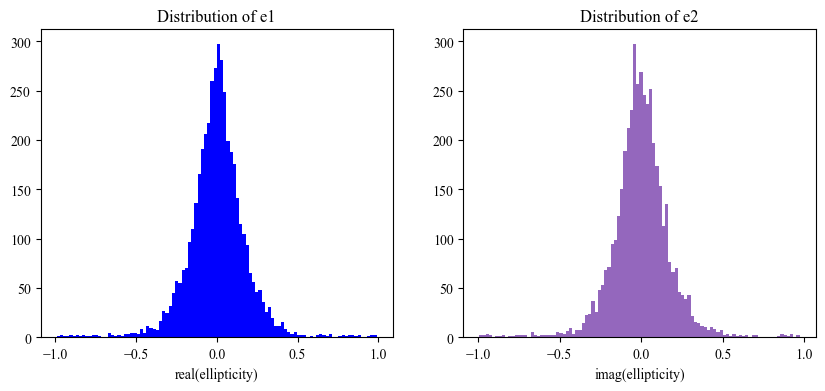

In [78]:
all_e = np.concatenate([e_array for e_array in e_glxys.values()]) # distributions of ellipticities
fig, ax = plt.subplots(1, 2,figsize=(10, 4))
ax[0].hist(all_e.real,bins=100,label='e1',color='blue')
ax[0].set_title('Distribution of e1')
ax[0].set_xlabel('real(ellipticity)')
ax[1].hist(all_e.imag,bins=100,label='e2',color='tab:purple')
ax[1].set_title('Distribution of e2')
ax[1].set_xlabel('imag(ellipticity)')
plt.show()

In [79]:
def stick_plot(ax, x, y, ellipticity, phi, bar_scaling=1, plot_index=None):
    '''Imput the positions of galaxies, magnitudee of the complex ellipticity '''
    ellipticity = ellipticity  * bar_scaling # making more elliptical galaxies loger bars
    del_y = ellipticity*np.sin(phi)
    del_x = ellipticity*np.cos(phi)
    # positions of ends of bar
    barx = np.array([x+del_x,x-del_x])
    bary = np.array([y+del_y,y-del_y])
    bars = np.array([barx,bary])
    
    #fig, ax = plt.subplots(figsize=(6,6))
    for i in range(len(ellipticity)):
        ax.plot(bars[0,:,i],bars[1,:,i],color='#EF2E72') 
        #ax.set_xticks([])
        #ax.set_yticks([])
        #ax.set_title('Showing Ellipticities of Galaxies')
        ax.set_box_aspect(1)

average q value of elliptical galaxies in x axis:  (-0.005927296303461094-0.004585020732650524j)
average q value of elliptical galaxies in y axis:  (-0.00022489999584758726-0.008074561162733621j)
average q value of elliptical galaxies in z axis:  (0.007695320502682879+0.001152481737114087j)


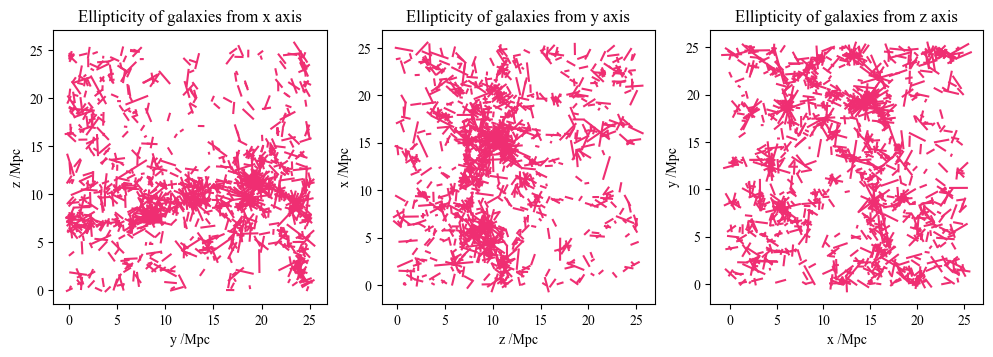

In [80]:
xyz = [['x',1,2],['y',2,0],['z',0,1]]
fig, ax = plt.subplots(1, 3,figsize=(12, 4))
for x_y_or_z in range(3):
    _ax_ = xyz[x_y_or_z][0] # which axis is perpendicular to the slice
    h = xyz[x_y_or_z][1] # horizontal axis
    v = xyz[x_y_or_z][2] # vertical axis

    #ax = fig.add_subplot(1,3,x_y_or_z+1)
    ax[x_y_or_z].set_xlabel(f'{xyz[h][0]} /Mpc')
    ax[x_y_or_z].set_ylabel(f'{xyz[v][0]} /Mpc')
    ax[x_y_or_z].set_title(f"Ellipticity of galaxies from {_ax_} axis")
    stick_plot(ax[x_y_or_z], pos_g3[:,h], pos_g3[:,v], np.absolute(e_glxys[_ax_]), np.angle(e_glxys[_ax_])/2, bar_scaling=2)
    print(f"average q value of elliptical galaxies in {_ax_} axis: ", np.mean(e_glxys[_ax_]))
plt.show()